## Estudo do projeto ModeloPreditivoInadimplencia

Estudo baseado no projeto do canal https://www.youtube.com/@nerddosdados

# Preparação 

Preparando os pacotes que irão ser utilizados e carregando os dados do banco de dados.

In [3]:
#Importação dos Pacotes
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
import pymssql as sql #conexão SQL

#Novos pacotes para testar tipos de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

In [4]:
#Importação dos arquivos direto do banco de dados MSSQL

# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from EXTRACAO_DADOS_SISTEMA', conexao)

# Fecha conexão com banco de dados
conexao.close()

## Análise

In [5]:
#Tamanho do conjunto de dados. 
df_original.shape

(10415, 20)

In [6]:
#Visão geral do conjunto de dados
df_original.head(5)

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TIPO_FINANCIAMENTO,TAXA_AO_ANO,PZ_FINANCIAMENTO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,INADIMPLENTE_COBRANCA
0,41637,2012-03-23,IMOBILIARIO,15.0,180,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,73767.0,471.29,70.0,SIM
1,67958,2012-01-24,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,323251.0,1858.69,28.0,SIM
2,68502,2014-05-23,IMOBILIARIO,18.0,200,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,529419.0,3123.57,60.0,SIM
3,68731,2015-10-23,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,499753.0,2873.58,41.0,SIM
4,68996,2017-01-24,IMOBILIARIO,17.0,200,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,722057.0,4224.03,63.0,SIM


In [7]:
# Analisando os dados missing podemos constatar o seguinte:
# Variavel DATA_ASSINATURA_CONTRATO possui 1 registro faltando
# Variavel VL_TOTAL_PC_PAGAS possui 4 registros faltando

# Como temos um total de 10.415 observações então excluir 5 observações NÃO afetará nosso trabalho

df_original.isnull().sum()

NUMERO_CONTRATO                   0
DATA_ASSINATURA_CONTRATO          0
TIPO_FINANCIAMENTO                0
TAXA_AO_ANO                       0
PZ_FINANCIAMENTO                  0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 4
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_FINANCIAMENTO               0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    1
INADIMPLENTE_COBRANCA             0
dtype: int64

In [8]:
#Informações básicas sobre tipos de variáveis
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NUMERO_CONTRATO                 10415 non-null  int64  
 1   DATA_ASSINATURA_CONTRATO        10415 non-null  object 
 2   TIPO_FINANCIAMENTO              10415 non-null  object 
 3   TAXA_AO_ANO                     10415 non-null  float64
 4   PZ_FINANCIAMENTO                10415 non-null  int64  
 5   CIDADE_CLIENTE                  10415 non-null  object 
 6   ESTADO_CLIENTE                  10415 non-null  object 
 7   RENDA_MENSAL_CLIENTE            10415 non-null  float64
 8   QT_PC_ATRASO                    10415 non-null  int64  
 9   QT_DIAS_PRIM_PC_ATRASO          10415 non-null  int64  
 10  QT_TOTAL_PC_PAGAS               10415 non-null  int64  
 11  VL_TOTAL_PC_PAGAS               10411 non-null  float64
 12  QT_PC_PAGA_EM_DIA               

In [9]:
# Avaliar o período dos dados coletados
inicio = pd.to_datetime(df_original['DATA_ASSINATURA_CONTRATO']).dt.date.min()
fim = pd.to_datetime(df_original['DATA_ASSINATURA_CONTRATO']).dt.date.max()
print('Período dos dados - De:', inicio, 'Até:',fim)

Período dos dados - De: 2012-01-10 Até: 2022-11-14


In [10]:
# Total de valores únicos de cada variável
# A variável TIPO_FINANCIAMENTO possui valor unico, então será retirada do nosso DataFrame

valores_unicos = []
for i in df_original.columns[0:20].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))

NUMERO_CONTRATO : 10415
DATA_ASSINATURA_CONTRATO : 1070
TIPO_FINANCIAMENTO : 1
TAXA_AO_ANO : 111
PZ_FINANCIAMENTO : 9
CIDADE_CLIENTE : 525
ESTADO_CLIENTE : 27
RENDA_MENSAL_CLIENTE : 7
QT_PC_ATRASO : 130
QT_DIAS_PRIM_PC_ATRASO : 227
QT_TOTAL_PC_PAGAS : 137
VL_TOTAL_PC_PAGAS : 9861
QT_PC_PAGA_EM_DIA : 129
QT_DIAS_MIN_ATRASO : 122
QT_DIAS_MAX_ATRASO : 534
QT_DIAS_MEDIA_ATRASO : 323
VALOR_FINANCIAMENTO : 834
VALOR_PARCELA : 1826
IDADE_DATA_ASSINATURA_CONTRATO : 79
INADIMPLENTE_COBRANCA : 2


In [11]:
# Visualizando algumas medidas estatisticas
df_original.describe()

,NUMERO_CONTRATO,TAXA_AO_ANO,PZ_FINANCIAMENTO,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO
count,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10411.000000,10415.000000,10415.000000,10415.000000,10415.000000,1.041500e+04,10415.000000,10414.000000
mean,95569.356889,17.271483,114.242535,5620.259241,16.716179,664.389438,35.946711,44528.545631,27.667115,6.115699,79.133845,28.841863,3.255909e+05,3617.341097,40.789418
std,34561.658949,2.566596,64.330109,2930.301113,30.706681,1181.352716,28.384415,65640.970502,25.153443,82.908021,334.871089,137.395374,1.774775e+05,1932.714754,12.390906
min,32709.000000,7.000000,48.000000,1800.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,2.932700e+04,185.740000,0.000000
25%,75868.500000,16.000000,72.000000,1800.000000,0.000000,0.000000,11.000000,8675.445000,7.000000,0.000000,0.000000,0.000000,2.100000e+05,2467.755000,31.250000
50%,79111.000000,17.000000,72.000000,7800.000000,0.000000,0.000000,33.000000,24345.600000,22.000000,1.000000,8.000000,4.000000,2.800000e+05,3470.590000,39.000000
75%,136637.500000,19.000000,180.000000,7800.000000,22.000000,1005.500000,54.000000,46787.290000,42.000000,3.000000,62.000000,22.000000,3.929738e+05,4930.245000,49.000000
max,155890.000000,25.500000,240.000000,9800.000000,178.000000,5655.000000,167.000000,714499.740000,136.000000,5465.000000,5710.000000,5480.000000,1.400000e+06,14410.000000,118.000000


In [12]:
print('Maior Valor Financiado:', df_original['VALOR_FINANCIAMENTO'].max())
print('Menor Valor Financiado:', df_original['VALOR_FINANCIAMENTO'].min())

Maior Valor Financiado: 1400000.0
Menor Valor Financiado: 29327.0


In [13]:
# A variavel alvo precisará ser balanceada na etapa de pré-processamento
df_original.groupby(['INADIMPLENTE_COBRANCA']).size()

INADIMPLENTE_COBRANCA
NAO    2377
SIM    8038
dtype: int64

In [14]:
# Aqui não precisaremos alterar nada
df_original.groupby(['PZ_FINANCIAMENTO']).size()

PZ_FINANCIAMENTO
48      343
72     6122
100     939
160       2
180     765
194       2
200     558
220     774
240     910
dtype: int64

In [15]:
# Aqui não precisaremos fazer nenhum tratamento
df_original.groupby(['RENDA_MENSAL_CLIENTE']).size()

RENDA_MENSAL_CLIENTE
1800.0    3512
3800.0      33
4800.0     416
5800.0    1039
6800.0     130
7800.0    4306
9800.0     979
dtype: int64

In [16]:
# Observe que temos uma variedade muito grande de valor financiado, neste caso devemos criar um range de valores
df_original.groupby(['VALOR_FINANCIAMENTO']).size()

VALOR_FINANCIAMENTO
29327.00         1
31421.00         3
39915.00         7
42574.00         7
45396.25         1
45789.00        18
46088.00         1
47574.00         1
55366.00         2
58658.00         1
60991.00         5
65054.00         3
66195.00         1
67439.00         1
67769.00         1
69967.00         3
71559.00        11
72284.00         1
73767.00         9
74050.00         1
75387.00         2
76700.00         2
77743.00         2
78714.00         2
79511.00         1
79706.00         1
80602.00         1
81323.00         4
82688.00         1
83409.00         1
83765.00         1
85303.00         1
85516.00         1
85870.00        15
86581.00         3
86741.00         6
86948.00         1
88748.00         3
92039.00         7
92116.00         2
92673.00         1
93027.00         1
93292.00        15
93378.00         5
95134.00         2
95677.00         1
96569.00         1
97336.00         1
97930.00         1
98949.00         2
99293.00         1
99594.00   

# Tratamento

In [17]:
# Excluindo os registros NA (5 registros)
df_original.dropna(inplace=True)

In [18]:
# Criando faixa de prazos para utilizarmos no modelo preditivo
bins = [-100, 120, 180, 240]
labels = ['Até 120 Meses', '121 até 180 Meses', '181 até 240 Meses']
df_original['FAIXA_PRAZO_FINANCIAMENTO'] = pd.cut(df_original['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_PRAZO_FINANCIAMENTO)

FAIXA_PRAZO_FINANCIAMENTO
Até 120 Meses        7402
181 até 240 Meses    2241
121 até 180 Meses     767
Name: count, dtype: int64

In [19]:
# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100000, 200000, 300000, 400000, 500000, 750000, 1000000, 9000000000]
labels = ['Até 100 mil', '101 até 200 mil', '201 até 300 mil', '301 até 400 mil', '401 até 500 mil', 
          '501 até 750 mil', 'De 751 até 1.000.000','Mais de 1.000.000']
df_original['FAIXA_VALOR_FINANCIADO'] = pd.cut(df_original['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_VALOR_FINANCIADO)

FAIXA_VALOR_FINANCIADO
201 até 300 mil         3949
301 até 400 mil         2098
101 até 200 mil         1823
401 até 500 mil         1128
501 até 750 mil          915
De 751 até 1.000.000     236
Até 100 mil              167
Mais de 1.000.000         94
Name: count, dtype: int64

In [20]:
# Podemos retirar a variável TIPO FINANCIAMENTO como vimos anteriormente
# Devemos retirar a variável VALOR_FINANCIAMENTO pois criamos uma variavel de faixa de valores para ela.
# Devemos retirar a variável PRAZO_FINANCIAMENTO pois criamos uma variavel de faixa de meses para ela.
# Podemos retirar a variável DATA_ASSINATURA_CONTRATO
# Podemos retirar a variável NUMERO_CONTRATO

colunas = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIADO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA']

df_dados = pd.DataFrame(df_original, columns=colunas)

In [21]:
df_dados.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,Até 100 mil,121 até 180 Meses,SIM
1,15.0,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,301 até 400 mil,181 até 240 Meses,SIM
2,18.0,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,501 até 750 mil,181 até 240 Meses,SIM
3,15.0,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,401 até 500 mil,181 até 240 Meses,SIM
4,17.0,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,501 até 750 mil,181 até 240 Meses,SIM


In [22]:
df_dados.shape

(10410, 17)

In [23]:
df_dados.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

In [24]:
df_dados.isnull().sum()

TAXA_AO_ANO                       0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 0
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    0
FAIXA_VALOR_FINANCIADO            0
FAIXA_PRAZO_FINANCIAMENTO         0
INADIMPLENTE_COBRANCA             0
dtype: int64

# Análise exploratória 

Nesta analise temos 2 objetivos: a variável alvo (INADIMPLENTE_COBRANCA), avaliar as variáveis categóricas para conhecimento dos dados e descartar variáveis que não fazem sentido.

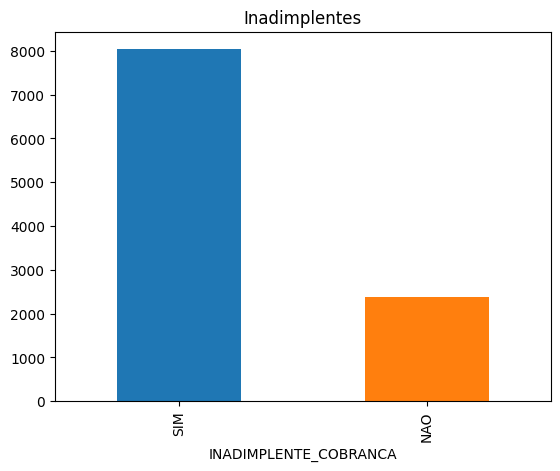

In [25]:
#Analisando como a variavel alvo está distribuida.
#Aqui podemos observar que há muito mais cotas como INADIMPLENTE
#dessa forma, precisaremos balancear o dataset mais adiante.
df_dados.INADIMPLENTE_COBRANCA.value_counts().plot(kind='bar', title='Inadimplentes',color = ['#1F77B4', '#FF7F0E']);


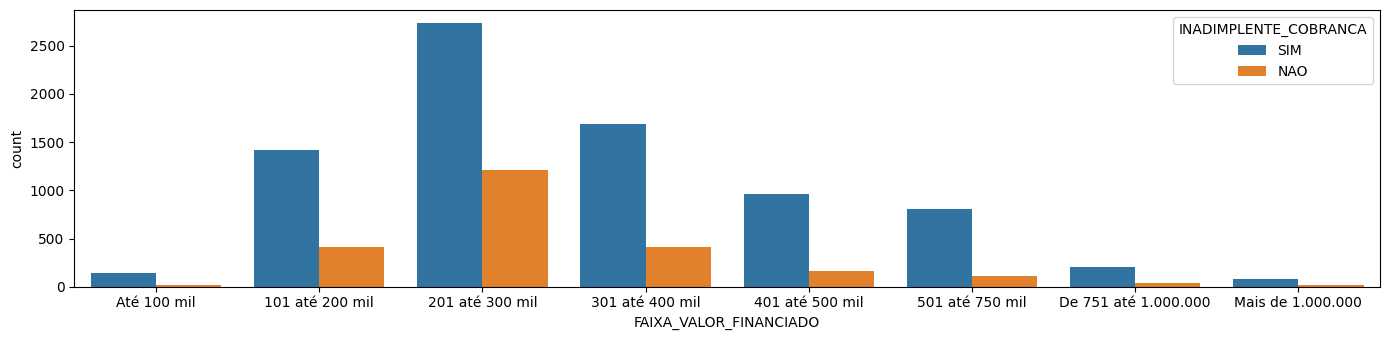

In [26]:
#Podemos constatar na analise que não há discrepancias nestas variaveis

plt.rcParams["figure.figsize"] = [14.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = df_dados, x = "FAIXA_VALOR_FINANCIADO", hue = "INADIMPLENTE_COBRANCA")
plt.show()

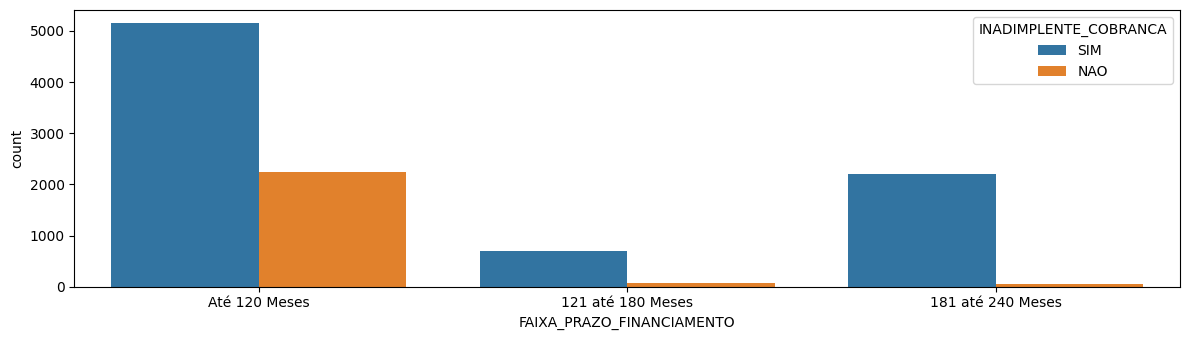

In [27]:
#Podemos constatar na analise que não há discrepancias nestas variaveis

plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = df_dados, x = "FAIXA_PRAZO_FINANCIAMENTO", hue = "INADIMPLENTE_COBRANCA")
plt.show()

# Analise de Variaveis numericas

In [28]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

In [29]:
#carregar variaveis para plot
variaveis_numericas = []
for i in df_dados.columns[0:17].tolist():
        if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':                        
            variaveis_numericas.append(i)    

In [30]:
#Visualizando as variáveis numéricas
variaveis_numericas

['TAXA_AO_ANO',
 'RENDA_MENSAL_CLIENTE',
 'QT_PC_ATRASO',
 'QT_DIAS_PRIM_PC_ATRASO',
 'QT_TOTAL_PC_PAGAS',
 'VL_TOTAL_PC_PAGAS',
 'QT_PC_PAGA_EM_DIA',
 'QT_DIAS_MIN_ATRASO',
 'QT_DIAS_MAX_ATRASO',
 'QT_DIAS_MEDIA_ATRASO',
 'VALOR_PARCELA',
 'IDADE_DATA_ASSINATURA_CONTRATO']

In [31]:
#Quantidade de variaveis
len(variaveis_numericas)

12

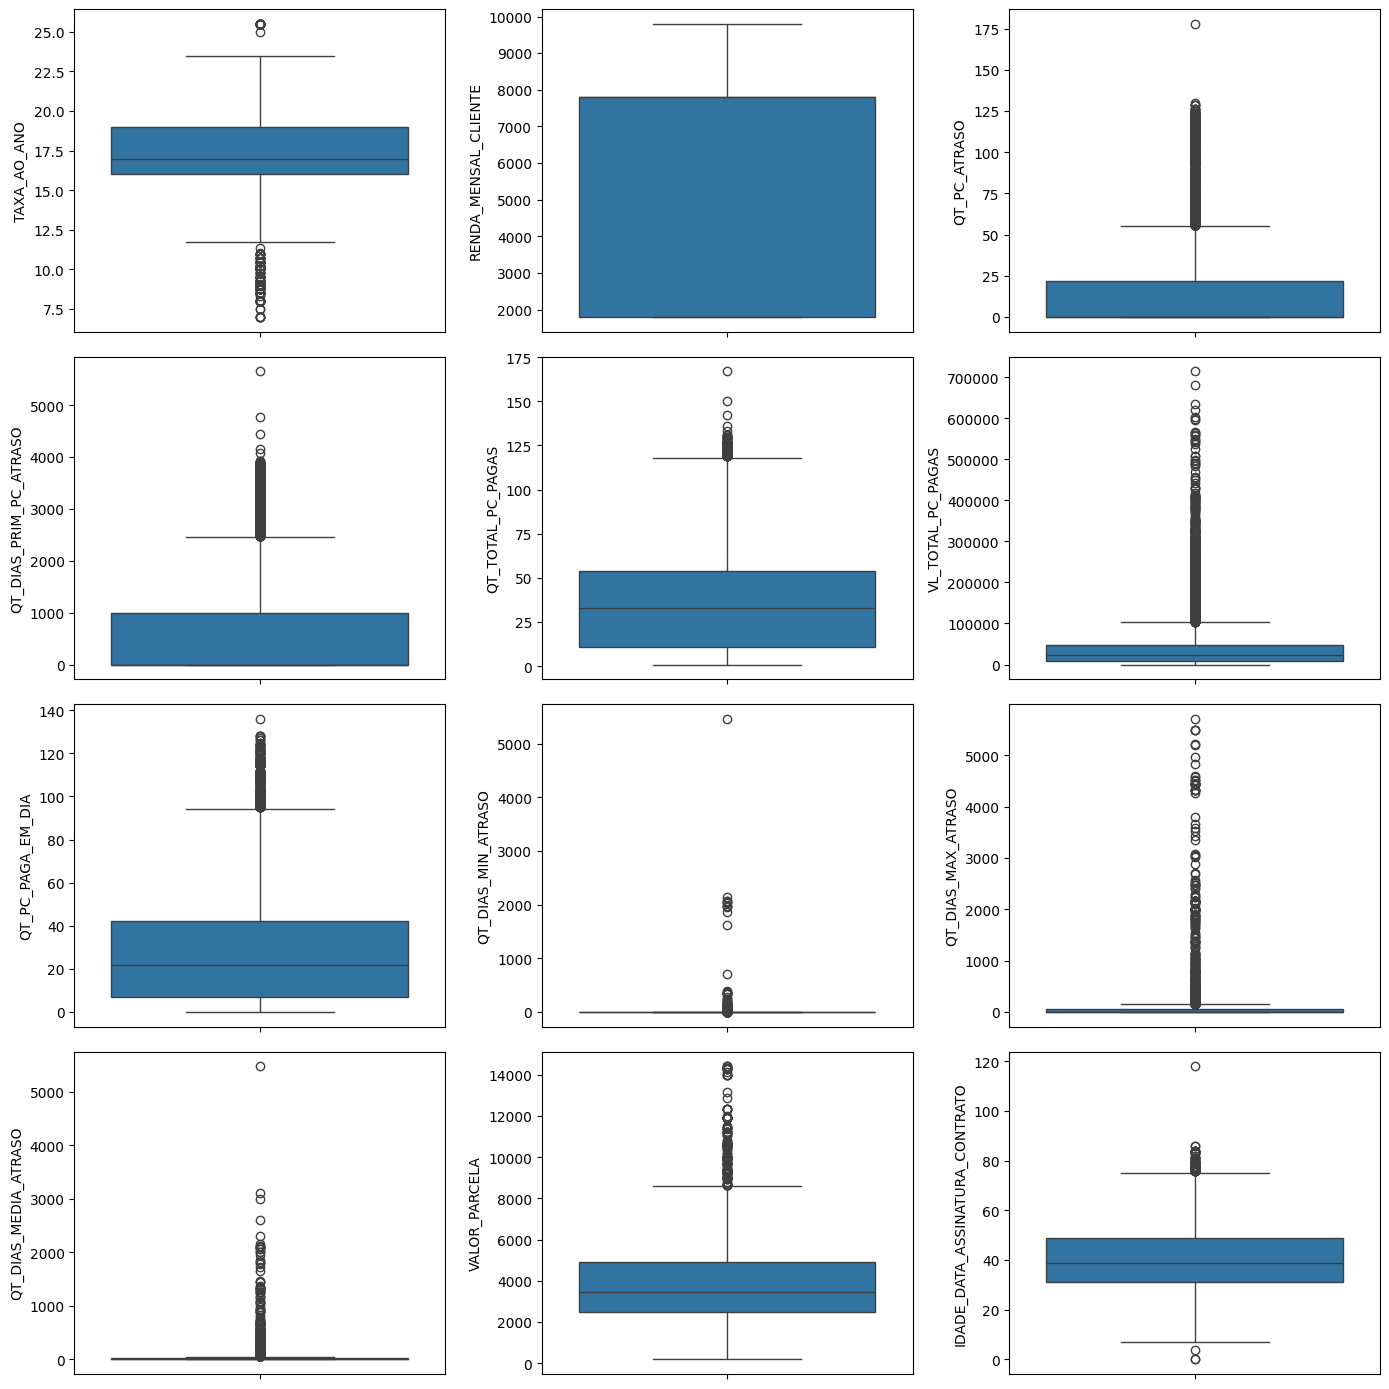

In [32]:
#Podemos observar nos boxplots abaixo que as variáveis númericas apresentam uma grande quantidade de "possíveis" outliers
#Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams["figure.figsize"] = [14.00, 14.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(4, 3) #4 linhas e 3 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            

plt.show()

In [33]:
# carregar variaveis categoricas para OneHotEncoding, ou seja transformar os campos categoricos em valores inteiros
# Colocamos o SLICE até 16 porque NÃO precisamos fazer OneHotEncoding para variavel TARGET
variaveis_categoricas = []
for i in df_dados.columns[0:16].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)    

In [34]:
# Visualizando as variaveis categoricas
variaveis_categoricas

['CIDADE_CLIENTE',
 'ESTADO_CLIENTE',
 'FAIXA_VALOR_FINANCIADO',
 'FAIXA_PRAZO_FINANCIAMENTO']

In [35]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

In [36]:
df_dados.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,5,0,SIM
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2,1,SIM
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4,1,SIM
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3,1,SIM
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4,1,SIM


In [37]:
# Visualizando os tipos das variaveis
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TAXA_AO_ANO                     10410 non-null  float64
 1   CIDADE_CLIENTE                  10410 non-null  int64  
 2   ESTADO_CLIENTE                  10410 non-null  int64  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64
 4   QT_PC_ATRASO                    10410 non-null  int64  
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64  
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64  
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64  
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64  
 12  VALOR_PARCELA                   10410

# Balanceamento

In [38]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_dados.INADIMPLENTE_COBRANCA.value_counts()
variavel_target

INADIMPLENTE_COBRANCA
SIM    8035
NAO    2375
Name: count, dtype: int64

In [39]:
#Separar variaveis preditoras e target
PREDITORAS = df_dados.iloc[:, 0:15]  
TARGET = df_dados.iloc[:, 16] 

In [40]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,5
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4


In [41]:
# Visualizando a variavel target
TARGET.head()

0    SIM
1    SIM
2    SIM
3    SIM
4    SIM
Name: INADIMPLENTE_COBRANCA, dtype: object

In [42]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

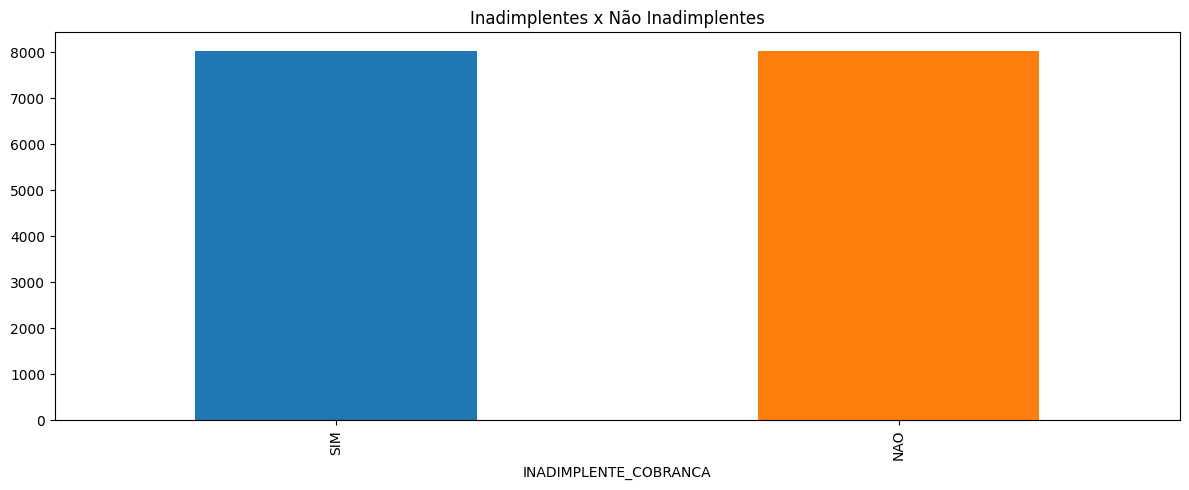

In [43]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Inadimplentes x Não Inadimplentes',color = ['#1F77B4', '#FF7F0E']);

In [44]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(10410, 15)

In [45]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(10410,)

In [46]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(16070, 15)

In [47]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(16070,)

# Separação e normalização dos dados / Criação e treino do modelo / Avaliação de métricas

In [48]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [49]:
# Normalizando as Variáveis - Pré Processamento dos Dados
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [50]:
# visualizando a dimensão dos dados de treino
X_treino_normalizados.shape

(11249, 15)

In [51]:
# visualizando os dados de treino normalizados
X_treino_normalizados

array([[0.45945946, 0.03816794, 0.15384615, ..., 0.50322829, 0.22033898,
        0.57142857],
       [0.66904491, 0.12977099, 0.23076923, ..., 0.40839172, 0.41221454,
        0.42857143],
       [0.59459459, 0.3110687 , 0.30769231, ..., 0.03970892, 0.25423729,
        0.        ],
       ...,
       [0.10810811, 0.3110687 , 0.30769231, ..., 0.16001324, 0.34745763,
        0.        ],
       [0.64864865, 0.86450382, 0.96153846, ..., 0.23265885, 0.44444926,
        0.14285714],
       [0.42432432, 0.10305344, 0.38461538, ..., 0.03852714, 0.3559322 ,
        0.        ]])

In [65]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [67]:
# Criando o classificador com SVC
clf2 = SVC()

# Construção do modelo
clf2 = clf2.fit(X_treino_normalizados, Y_treino)

In [68]:
# Criando o classificador com Logistic Regression
clf3 = LogisticRegression()

# Construção do modelo
clf3 = clf3.fit(X_treino_normalizados, Y_treino)

In [69]:
# Criando o classificador com Decision Tree 
clf4 = DecisionTreeClassifier()

# Construção do modelo
clf4 = clf4.fit(X_treino_normalizados, Y_treino)

In [70]:
# Criando o classificador com KNeighbors
clf5 = KNeighborsClassifier()

# Construção do modelo
clf5 = clf5.fit(X_treino_normalizados, Y_treino)

In [71]:
# Criando o classificador com MLP
clf6 = MLPClassifier()

# Construção do modelo
clf6 = clf6.fit(X_treino_normalizados, Y_treino)

In [72]:
# Criando o classificador com Gradient Boosting
clf7 = GradientBoostingClassifier()

# Construção do modelo
clf7 = clf7.fit(X_treino_normalizados, Y_treino)

In [74]:
# # Criando o classificador com XGB
# clf8 = XGBClassifier()

# # Construção do modelo
# clf8 = clf8.fit(X_treino_normalizados, Y_treino)

In [75]:
# Criando o classificador com LGBM
clf9 = LGBMClassifier()

# Construção do modelo
clf9 = clf9.fit(X_treino_normalizados, Y_treino)

[LightGBM] [Info] Number of positive: 5610, number of negative: 5639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 11249, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498711 -> initscore=-0.005156
[LightGBM] [Info] Start training from score -0.005156


In [53]:
# Verificando a acuracia do modelo com dados de teste Random Forest
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9193113461937358

In [76]:
# Verificando a acuracia do modelo com dados de teste SVC
scores = clf2.score(X_teste_normalizados,Y_teste)
scores

0.8452603194358017

In [77]:
# Verificando a acuracia do modelo com dados de teste Logistic Regression
scores = clf3.score(X_teste_normalizados,Y_teste)
scores

0.7934038581207219

In [78]:
# Verificando a acuracia do modelo com dados de teste Decision Tree 
scores = clf4.score(X_teste_normalizados,Y_teste)
scores

0.8740925119269861

In [79]:
# Verificando a acuracia do modelo com dados de teste KNeighbors
scores = clf5.score(X_teste_normalizados,Y_teste)
scores

0.8678697365691765

In [80]:
# Verificando a acuracia do modelo com dados de teste MLP
scores = clf6.score(X_teste_normalizados,Y_teste)
scores

0.8539722049367351

In [81]:
# Verificando a acuracia do modelo com dados de teste Gradient Boosting
scores = clf7.score(X_teste_normalizados,Y_teste)
scores

0.8859157851068243

In [82]:
# # Verificando a acuracia do modelo com dados de teste XGB
# scores = clf8.score(X_teste_normalizados,Y_teste)
# scores

In [83]:
# Verificando a acuracia do modelo com dados de teste LGBM
scores = clf9.score(X_teste_normalizados,Y_teste)
scores

0.9161999585148309

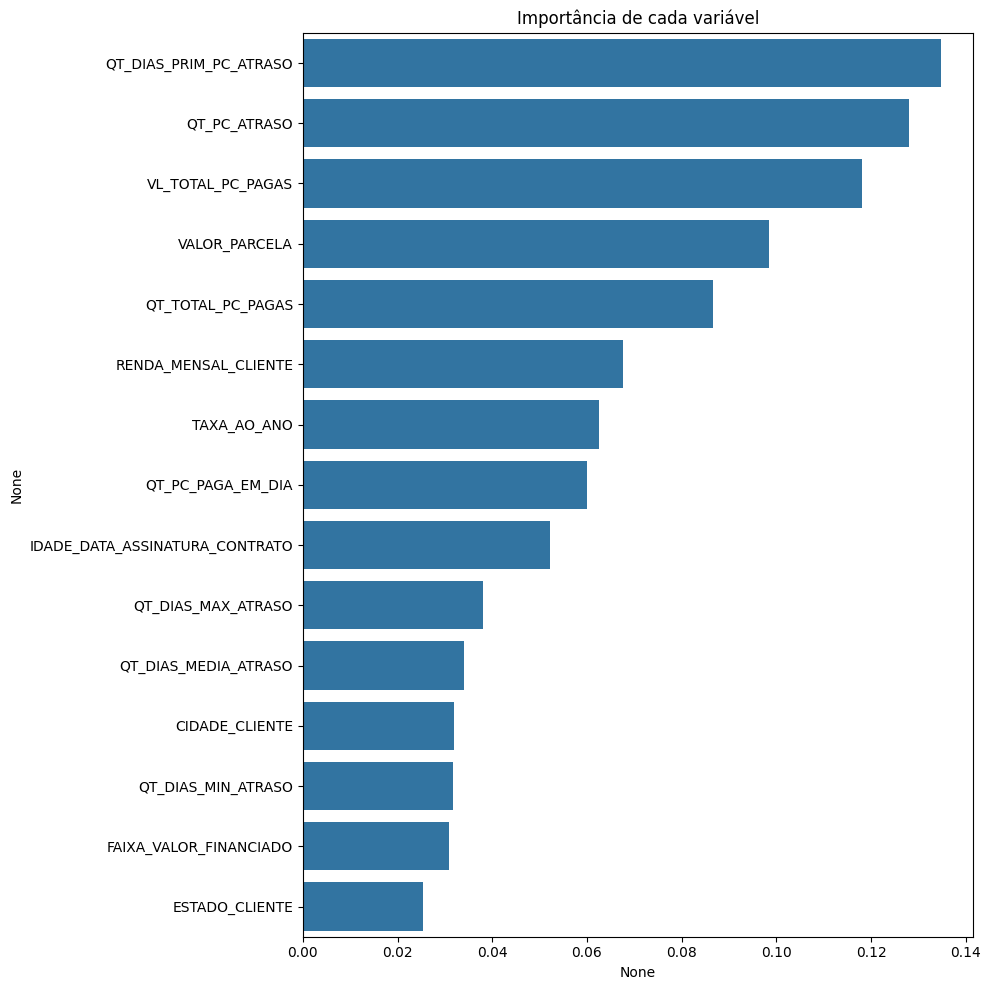

In [54]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [55]:
importances.sort_values(ascending = False)

QT_DIAS_PRIM_PC_ATRASO            0.134759
QT_PC_ATRASO                      0.127913
VL_TOTAL_PC_PAGAS                 0.118036
VALOR_PARCELA                     0.098386
QT_TOTAL_PC_PAGAS                 0.086662
RENDA_MENSAL_CLIENTE              0.067553
TAXA_AO_ANO                       0.062624
QT_PC_PAGA_EM_DIA                 0.060074
IDADE_DATA_ASSINATURA_CONTRATO    0.052102
QT_DIAS_MAX_ATRASO                0.038027
QT_DIAS_MEDIA_ATRASO              0.034097
CIDADE_CLIENTE                    0.031973
QT_DIAS_MIN_ATRASO                0.031767
FAIXA_VALOR_FINANCIADO            0.030755
ESTADO_CLIENTE                    0.025272
dtype: float64

In [56]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_treinado.pk')

['modelo_treinado.pk']

# Preparação para produção

In [57]:
# Carregando o modelo treinado
clf = joblib.load('modelo_treinado.pk')

In [58]:
#Importação do arquivo de dados

# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from EXTRACAO_DADOS_SISTEMA', conexao)

# Fecha conexão com banco de dados
conexao.close()

In [59]:
# Excluindo dados missing
df_original.dropna(inplace=True)


# Criando faixa de prazos para utilizarmos no modelo preditivo
bins = [-100, 120, 180, 240]
labels = ['Até 120 Meses', '121 até 180 Meses', '181 até 240 Meses']
df_original['FAIXA_PRAZO_FINANCIAMENTO'] = pd.cut(df_original['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_PRAZO_FINANCIAMENTO)


# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100000, 200000, 300000, 400000, 500000, 750000, 1000000, 9000000000]
labels = ['Até 100 mil', '101 até 200 mil', '201 até 300 mil', '301 até 400 mil', '401 até 500 mil', 
          '501 até 750 mil', 'De 751 até 1.000.000','Mais de 1.000.000']
df_original['FAIXA_VALOR_FINANCIADO'] = pd.cut(df_original['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_VALOR_FINANCIADO)

columns = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIADO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA',]

df_dados = pd.DataFrame(df_original, columns=columns)

# carregar variaveis categoricas para OneHotEncoding
variaveis_categoricas = []
for i in df_dados.columns[0:16].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i) 

lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])



# Separar variaveis preditoras
PREDITORAS = df_dados.iloc[:, 0:15]          
    

# Fazendo a normalização dos dados    
Normalizador = MinMaxScaler()
dados_normalizados = Normalizador.fit_transform(PREDITORAS)

previsoes = clf.predict(dados_normalizados)
probabilidades = clf.predict_proba(dados_normalizados)
df_original['PREVISOES'] = previsoes
df_original['PROBABILIDADES'] = probabilidades[:, 1]
df_original.head()

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TIPO_FINANCIAMENTO,TAXA_AO_ANO,PZ_FINANCIAMENTO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,INADIMPLENTE_COBRANCA,FAIXA_PRAZO_FINANCIAMENTO,FAIXA_VALOR_FINANCIADO,PREVISOES,PROBABILIDADES
0,41637,2012-03-23,IMOBILIARIO,15.0,180,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,73767.0,471.29,70.0,SIM,121 até 180 Meses,Até 100 mil,SIM,0.983333
1,67958,2012-01-24,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,323251.0,1858.69,28.0,SIM,181 até 240 Meses,301 até 400 mil,SIM,0.973333
2,68502,2014-05-23,IMOBILIARIO,18.0,200,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,529419.0,3123.57,60.0,SIM,181 até 240 Meses,501 até 750 mil,SIM,0.993333
3,68731,2015-10-23,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,499753.0,2873.58,41.0,SIM,181 até 240 Meses,401 até 500 mil,SIM,0.883333
4,68996,2017-01-24,IMOBILIARIO,17.0,200,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,722057.0,4224.03,63.0,SIM,181 até 240 Meses,501 até 750 mil,SIM,0.993333


In [60]:
df_original.to_excel('df_original_com_probabilidades.xlsx', index = False)

# Criando nova tabela e inserindo os dados de predição no sql

In [61]:
# Separando as colunas que serão utilizadas para inserção
columns = ['NUMERO_CONTRATO', 'PREVISOES', 'PROBABILIDADES']
df_conversao = pd.DataFrame(df_original, columns=columns)
df_conversao.head()

,NUMERO_CONTRATO,PREVISOES,PROBABILIDADES
0,41637,SIM,0.983333
1,67958,SIM,0.973333
2,68502,SIM,0.993333
3,68731,SIM,0.883333
4,68996,SIM,0.993333


In [62]:
import pymssql as sql
# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')

# Criando um cursor e executando um LOOP no DataFrame para fazer o INSERT no banco SQL Server

cursor = conexao.cursor()

for index,row in df_conversao.iterrows():
    sql = "INSERT INTO RESULTADOS_INTERMEDIARIO (NUMERO_CONTRATO, PREVISOES, PROBABILIDADES) VALUES (%s, %s, %s)"
    val = (row['NUMERO_CONTRATO'],row['PREVISOES'],row['PROBABILIDADES'])    
    cursor.execute(sql, val)
    conexao.commit()
    


print("Dados inseridos com sucesso no SQL")   

Dados inseridos com sucesso no SQL


In [63]:
import pymssql as sql
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')
cursor = conexao.cursor()
cursor.execute('EXEC SP_INPUT_RESULTADOS_MODELO_PREDITIVO')    
conexao.commit()
conexao.close()

In [64]:
import pymssql as sql
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')
cursor = conexao.cursor()
cursor.execute('TRUNCATE TABLE RESULTADOS_INTERMEDIARIO')
conexao.commit()
conexao.close()